# Transfer Learning with Tensorflow Part 1:Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns in our problems.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using the GPU?
!nvidia-smi

Sat Feb  4 01:49:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with data

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the download file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-02-04 01:49:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 108.177.127.128, 2a00:1450:4013:c07::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  39.8MB/s    in 4.7s    

2023-02-04 01:49:07 (34.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'' use the `ImageDataGenerator` class to load our images in batches.

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing Images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model train)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckPoint callback
* Stopping a model from training (before it trains too long and overfits) with the Earlystopping callback

In [5]:
# Create Tensorboard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using Tensorflow Hub

In the past we've used Tensorflow to create our own models layer by layer from scratch. Now we're going to do a similar process, except the majority of our model's layers are going to come from Tensorflow Hub.

We can access pretrained models on tfhub.dev

In [6]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"


efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Lets make a create model() function to create a model from the URL
def create_model(model_url, num_classes=10):
  """
  Takes a Tensorflow Hub URL and creates Keras Sequential model with it.

  Args:
    model_url (str) : A Tensorflow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10
    Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
      layer and Dense output layer with num_classes output neurons.
    """
  # Download the pretrained model and save it as keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet Tensorflow Hub Feature Extraction model

In [9]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
# compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
# Let's fit our resnet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50v2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20230204-014920
Epoch 1/5
24/24 [==============================] - 31s 865ms/step - loss: 1.8148 - accuracy: 0.4040 - val_loss: 1.1821 - val_accuracy: 0.6212
Epoch 2/5
24/24 [==============================] - 16s 705ms/step - loss: 0.8905 - accuracy: 0.7373 - val_loss: 0.8521 - val_accuracy: 0.7304
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.6032 - accuracy: 0.8360 - val_loss: 0.7554 - val_accuracy: 0.7584
Epoch 4/5
24/24 [==============================] - 16s 697ms/step - loss: 0.4773 - accuracy: 0.8800 - val_loss: 0.7004 - val_accuracy: 0.7720
Epoch 5/5
24/24 [==============================] - 18s 764ms/step - loss: 0.3760 - accuracy: 0.9107 - val_loss: 0.6719 - val_accuracy: 0.7792


Our transfer learning feature extractor model out performed ALL of the previous models we built by hand.. and in a quicker training time AND with only 10 % of training examples.

In [13]:
# Let's create a function to plot our loss curves
# You could put a function like this into a script called "helper.py" and import it whenever needed
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.

  Args:
    history: Tensorflow History object.
  
  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

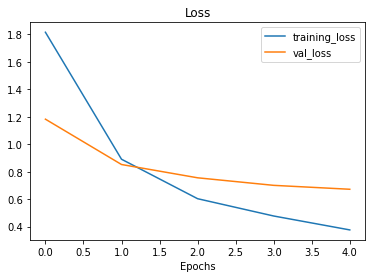

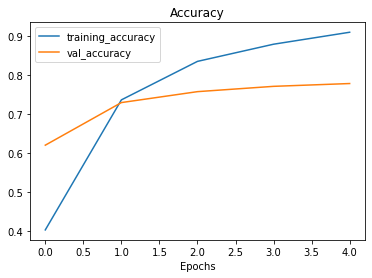

In [14]:
plot_loss_curves(resnet_history)

### Creating and Testing EfficientNetB0 Tensorflow Hub Feature Extraction model

In [15]:
# Create EfficientNetB0 feature extraction model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile Efficient net model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit the EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230204-020841
Epoch 1/5
24/24 [==============================] - 26s 702ms/step - loss: 1.7811 - accuracy: 0.4707 - val_loss: 1.2481 - val_accuracy: 0.7340
Epoch 2/5
24/24 [==============================] - 16s 705ms/step - loss: 1.0286 - accuracy: 0.7773 - val_loss: 0.8393 - val_accuracy: 0.8288
Epoch 3/5
24/24 [==============================] - 14s 622ms/step - loss: 0.7401 - accuracy: 0.8360 - val_loss: 0.6835 - val_accuracy: 0.8464
Epoch 4/5
24/24 [==============================] - 15s 630ms/step - loss: 0.5953 - accuracy: 0.8640 - val_loss: 0.6023 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.5096 - accuracy: 0.8853 - val_loss: 0.5517 - val_accuracy: 0.8660


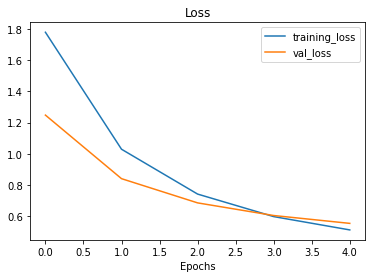

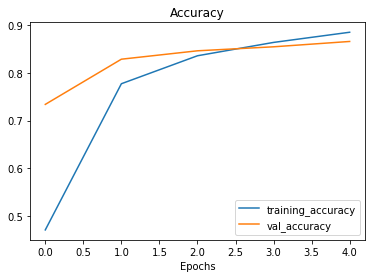

In [16]:
plot_loss_curves(efficientnet_history)

In [17]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [18]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [19]:
# How many layers does our efficientnet_model has
len(efficientnet_model.layers[0].weights)

309

##Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature Extraction"** transfer learning - use the prelearned patterns of an exisitng model (e.g., EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes of Imagenet to 10)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new ouput layers)

## Comparing our models results using TensorBoard

> **Note:** When you upload things to Tensorboard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to tensorboard.dev.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetb0 vs. ResNet50v2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

Our Tensorboard experiments are uploaded publically here: https://tensorboard.dev/experiment/NC31o9UoQYGv2OuLYFx4qA/

In [22]:
# Check out what Tensorboard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/NC31o9UoQYGv2OuLYFx4qA/
	Name                 EfficientNetb0 vs. ResNet50v2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   NC31o9UoQYGv2OuLYFx4qA
	Created              2023-02-04 02:36:53 (3 minutes ago)
	Updated              2023-02-04 02:36:56 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918466
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
#!tensorboard dev delete --experiment_id NC31o9UoQYGv2OuLYFx4qA

In [23]:
# Confirm the deletion by re-checking the experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/NC31o9UoQYGv2OuLYFx4qA/
	Name                 EfficientNetb0 vs. ResNet50v2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   NC31o9UoQYGv2OuLYFx4qA
	Created              2023-02-04 02:36:53 (5 minutes ago)
	Updated              2023-02-04 02:36:56 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918466
Total: 1 experiment(s)
